to run this notebook <a href="https://colab.research.google.com/drive/1iIdVOvemJk4HPxs1F8T-f_poZqB-Y3N0?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# Ensemble CLustering

The purpose of this notebook is to provide an example of using the ensemble clustering algorithm, and to compare its performance with the clustering method proposed in the sklearn library.

## Importing the "Clustering_Ensemble" package

In [4]:
import requests

def download_clustering_ensemble_algorithme():

    ensemble_clustering = open("ensemble_clustering.py", "w")
    clusteringNormalizedCuts = open("ClusteringNormalizedCuts.py", "w")
    
    url1 = "https://raw.githubusercontent.com/Yanis2016/Clustering-Ensemble/master/ensemble_clustering.py"
    url2 = "https://raw.githubusercontent.com/Yanis2016/Clustering-Ensemble/master/ClusteringNormalizedCuts.py"

    ensemble_clustering.write(requests.get(url1).text)
    clusteringNormalizedCuts.write(requests.get(url2).text)
    ensemble_clustering.close()
    clusteringNormalizedCuts.close()
    
    print("the download was successful.")

download_clustering_ensemble_algorithme()

the download was successful.


In [5]:
# Import the model
from ensemble_clustering import EnsembleClustering
 
# View Documentation
help(EnsembleClustering)

Help on class EnsembleClustering in module ensemble_clustering:

class EnsembleClustering(builtins.object)
 |  EnsembleClustering(n_clusters=4, n_partitions=1000, max_iter=4, k_type='Fixed', cons_validation='ac', m=3, alpha=0.5)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_clusters=4, n_partitions=1000, max_iter=4, k_type='Fixed', cons_validation='ac', m=3, alpha=0.5)
 |      Clustering Ensemble.
 |      
 |      Operating principle:
 |      ---------
 |          1 - generation of several partitions using the K Means algorithm with k 
 |              varies between 2 and sqrt (n_sample).
 |      
 |          2 - update of the co-association matrix.
 |      
 |          3 - generation of partitions by applying the clustering algorithm based on normalized cuts 
 |              on the co_assiation matrix when the negative proof is removed.
 |      
 |          4 - selection of the final score with a higher degree of confidence.
 |      
 |      Parameters
 |      ----------
 |

## Comparison of the proposed ensemble clustering algorithm with the individual clustering methods proposed in sklearn.

this code is provided can be found <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-download-auto-examples-cluster-plot-cluster-comparison-py">here</a>  in to which we added the ensemble clustering model together, to visually compare with the different approaches used

Automatically created module for IPython interactive environment


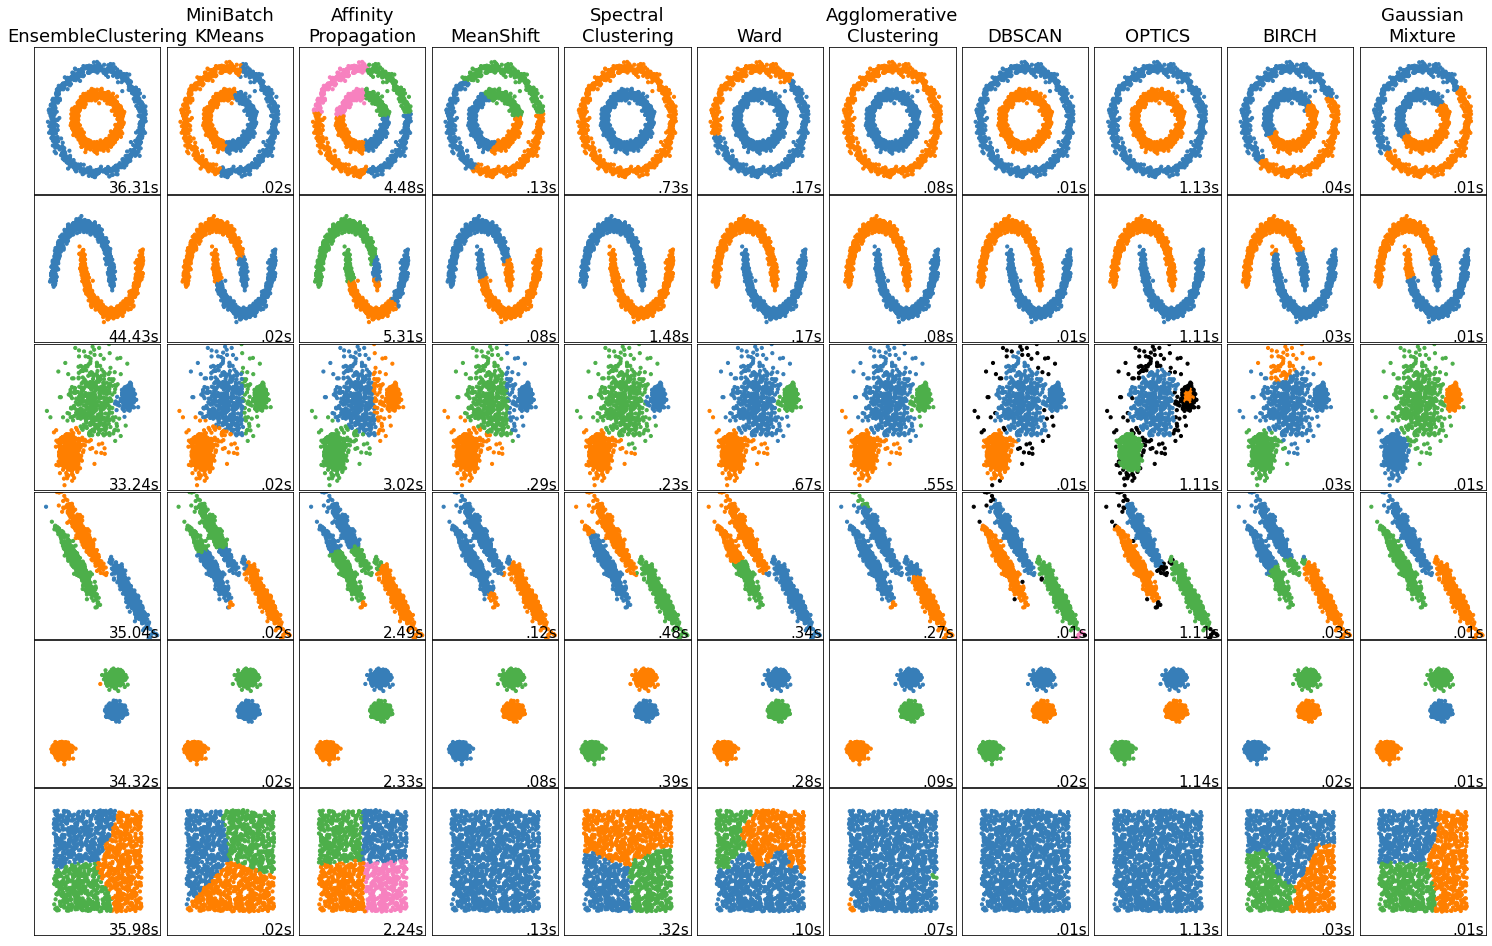

In [6]:
print(__doc__)
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from ensemble_clustering import EnsembleClustering

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ensemble_clustering = EnsembleClustering(n_clusters=params["n_clusters"])
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('EnsembleClustering', ensemble_clustering),
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## Test and compare the ensemble clustering algorithm with the most used clustering model which is the Kmeans on the iris data

# Importing Libraries

In [7]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score

## Test the model on the iris data, and compare it with the KMeans

In [8]:
# Importing iris data
iris = pd.DataFrame(datasets.load_iris()["data"], columns=datasets.load_iris()["feature_names"]).join(pd.DataFrame(datasets.load_iris()["target"], columns=["target"]).astype("category"))

# Display the dimensions of the dataframe
print(f"Dimesions:\n\trow : {iris.shape[0]}\n\tcol : {iris.shape[1]}\n")

# Display the first 5 lines of the dataframe
iris.head()


Dimesions:
	row : 150
	col : 5



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


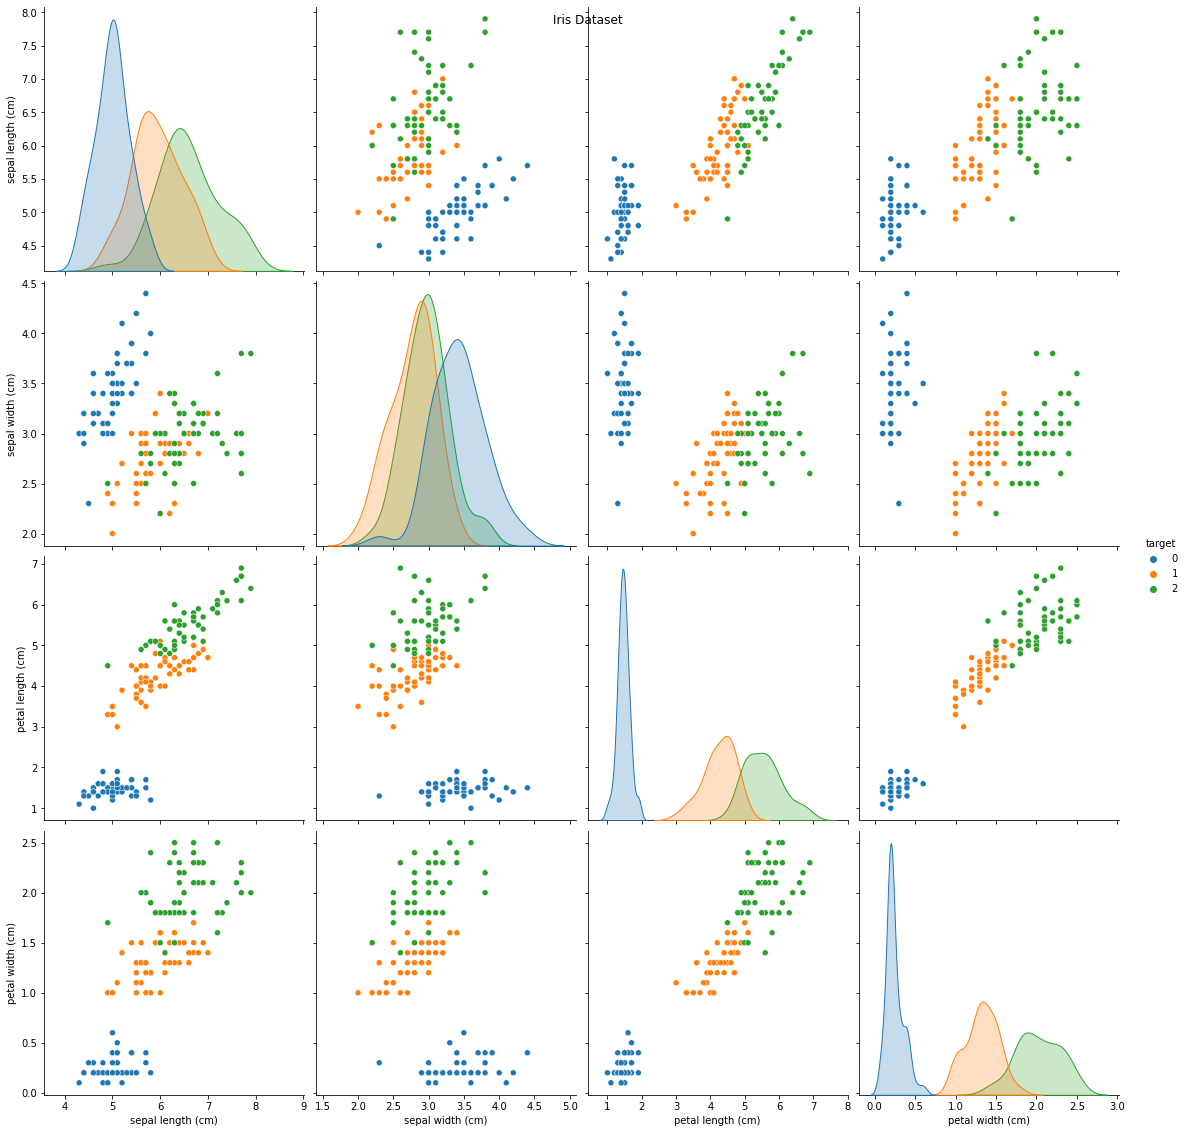

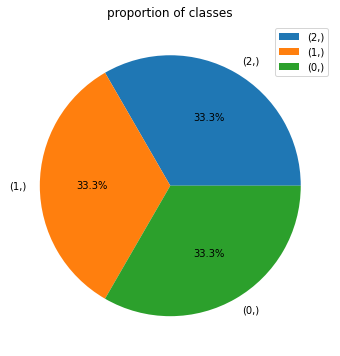

In [9]:
# Data visualization
sns.pairplot(iris, hue="target", height=4).fig.suptitle("Iris Dataset")
plt.show()

# Display the proportion of class
pd.DataFrame(iris.target).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="proportion of classes")
plt.legend()
plt.show()

In [10]:
# Initialize and train the kmean model
kmean = KMeans(n_clusters=3).fit(iris.drop(columns=["target"]))

# Recover mabel calculated by kmean
pred_kmean = kmean.labels_

# Evaluate the results of the kmean
print("Kmean score :", adjusted_mutual_info_score(iris.target, pred_kmean))

Kmean score : 0.7551191675800484


clustering_ensemble score : 0.8032287370935435


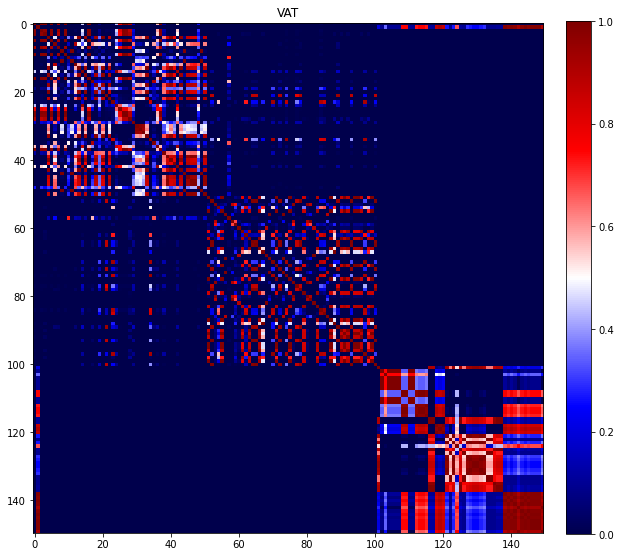

In [11]:
# Initialize and train the clustering_ensemble model
ens_clust = EnsembleClustering(n_clusters=3).fit(iris.drop(columns=["target"]))
 
# Recover mabel calculated by clustering_ensemble
pred_ens_clust = ens_clust.labels
 
# Evaluate the results of clustering_ensemble
print("clustering_ensemble score :", adjusted_mutual_info_score(iris.target, pred_ens_clust))
 
# Display the co-association matrix
ens_clust.draw_vat()

The co-association matrix allows us to determine the number of existing clusters in the data, so you can first run the model with a random number of cluster number, then view the “VAT” matrix, in order to estimate the number of cluster.

The clustering ensemble model is used in cases where we cannot visualize the data, so we cannot know which of the existing models to choose in order to detect the underlying structures existing in the data, moreover this algorithm is tested on 16 different data types (text, numerics, images ... ect) and always gives good results

### for more information contact me on: yanis.aithammou@outlook.fr